In [80]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pandas as pd
import numpy as np
import pystan
import seaborn as sns
import scipy

In [81]:
cols = [#'bayesian_prediction_std_bal_acc',
        #'bayesian_prediction_std_f1_score', 
        #'bayesian_prediction_std_auc',
        'epochs',
        'bayesian_entropy__bal_acc', 
        #'bayesian_entropy_f1_score',
        'bayesian_entropy__auc']

In [82]:
#experiments = ['bayesian', 'mlp_dropout', 'mlp_deterministic', 'poor_bayesian']
experiments = ['mlp_dropout', 'mlp_deterministic', 'poor_bayesian']

In [83]:
dfs = []
for exp in experiments:
    df_with = pd.read_csv(exp+'_uncertainty_with_unknown.csv')
    df_with_results = df_with.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    df_without = pd.read_csv(exp+'_uncertainty_without_unknown.csv')
    df_without_results = df_without.groupby(['inside_labels', 'unknown_labels']).mean()[cols]
    dfs.append([exp, df_with_results, df_without_results])

In [84]:
results_cols = ['inside', 'outside',
                'in_epochs', 'out_epochs',
                'in_entropy_acc', 'out_entropy_acc',
                'in_entropy_auc', 'out_entropy_auc']

dfs_results = []
for exp, df_with, df_without in dfs:
    results = pd.DataFrame(columns=results_cols)
    for (in_key, *in_row), (out_key, *out_row) in zip(df_with.itertuples(), df_without.itertuples()):
        assert in_key == out_key
        results.loc[len(results)] = [
            in_key[0], in_key[1],
            in_row[0], out_row[0],
            in_row[1], out_row[1],
            in_row[2], out_row[2],
        ]
    dfs_results.append([exp, results])

In [85]:
final_results_cols = ['inside', 'outside']
for c in results_cols[2:]:
    for exp, _ in dfs_results:
        final_results_cols.append(exp+'_'+c)

In [86]:
final_results = pd.DataFrame(columns=final_results_cols)
for key_row  in zip(*[df.itertuples() for exp, df in dfs_results]):
    for i in range(1, len(key_row)):
        _, *prev_row = key_row[i-1]
        _, *row = key_row[i]
        assert prev_row[0] == row[0]
        assert prev_row[1] == row[1]
        
    _, *row = key_row[0]
    new_row = [row[0], row[1]]
    
    for c in range(2, len(results_cols)):
        for _, *row in key_row:
            new_row.append(row[c])

    final_results.loc[len(final_results)] = new_row

In [87]:
final_results.columns

Index(['inside', 'outside', 'mlp_dropout_in_epochs',
       'mlp_deterministic_in_epochs', 'poor_bayesian_in_epochs',
       'mlp_dropout_out_epochs', 'mlp_deterministic_out_epochs',
       'poor_bayesian_out_epochs', 'mlp_dropout_in_entropy_acc',
       'mlp_deterministic_in_entropy_acc', 'poor_bayesian_in_entropy_acc',
       'mlp_dropout_out_entropy_acc', 'mlp_deterministic_out_entropy_acc',
       'poor_bayesian_out_entropy_acc', 'mlp_dropout_in_entropy_auc',
       'mlp_deterministic_in_entropy_auc', 'poor_bayesian_in_entropy_auc',
       'mlp_dropout_out_entropy_auc', 'mlp_deterministic_out_entropy_auc',
       'poor_bayesian_out_entropy_auc'],
      dtype='object')

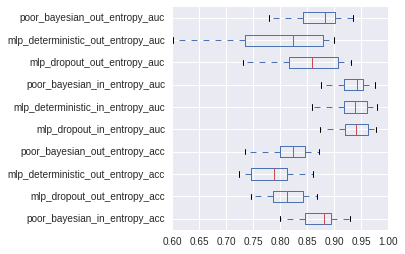

In [88]:
plt.figure()
plt.rcParams['figure.figsize'] = (10, 10)
final_results.boxplot(return_type='axes', vert=False, column=list(final_results.columns)[10:])
plt.subplots_adjust(left=0.4)

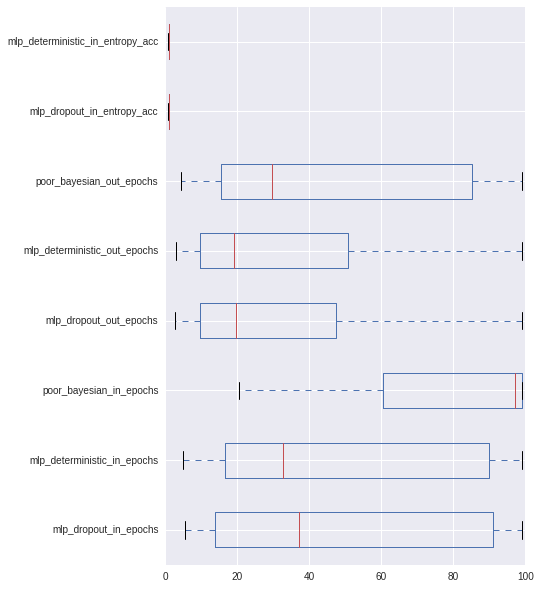

In [89]:
plt.figure()
plt.rcParams['figure.figsize'] = (10, 5)
final_results.boxplot(return_type='axes', vert=False, column=list(final_results.columns)[2:10])
plt.subplots_adjust(left=0.4)

In [90]:
code = '''
data {
    int K; // Number of groups
    int N; // Number of examples per group
    real y[N, K]; // Observations 
}
parameters {
    real mu; // Mean
    vector[K-1] theta_free; // Effects
    real<lower=0> sigma; // Noise std
}
model {
    vector[K] theta; // Effects including the first effect which shall be forced to zero for identifiability purposes
    theta[1] <- 0.0;
    for (i in 2:K) theta[i] <- theta_free[i-1];
    theta_free ~ normal(0, 100); // Weak effect prior

    sigma ~ normal(0, 100); // Weak noise std prior (half-normal)
    
    for (i in 1:N)
        for (j in 1:K)
            y[i][j] ~ normal(mu + theta[j], sigma); // Normal likelihood
}
'''

model = pystan.StanModel(model_code=code)

In [91]:
y_out = final_results[['mlp_deterministic_out_entropy_acc', 'mlp_dropout_out_entropy_acc', 'poor_bayesian_out_entropy_acc']].values
y_out = scipy.special.logit(y_out)

y_in = final_results[['mlp_deterministic_in_entropy_acc', 'mlp_dropout_in_entropy_acc', 'poor_bayesian_in_entropy_acc']].values
y_in = scipy.special.logit(y_in)

In [92]:
y = y_in
(N, K) = y.shape

data = {'K': K, 'N': N, 'y': y}
fit = model.sampling(data=data, iter=1000, chains=4)

/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction

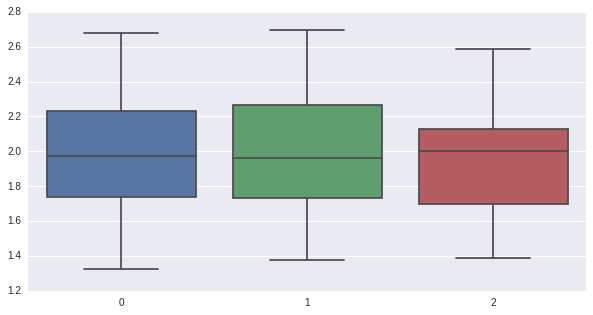

Inference for Stan model: anon_model_a6be83174308d49bd735f24dec530cac.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu               2.0  1.8e-3   0.08   1.85   1.94    2.0   2.06   2.16   2000   1.01
theta_free[0]-8.2e-3  2.6e-3   0.11  -0.23  -0.09-8.7e-3   0.07   0.21   2000   1.01
theta_free[1]  -0.02  2.7e-3   0.12  -0.25   -0.1  -0.01   0.07   0.21   2000    1.0
sigma           0.36  7.8e-4   0.03    0.3   0.34   0.36   0.38   0.44   2000    1.0
lp__           30.36    0.03   1.44  26.74  29.62  30.71  31.42  32.16   2000   1.01

Samples were drawn using NUTS(diag_e) at Sat Oct 15 04:12:46 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


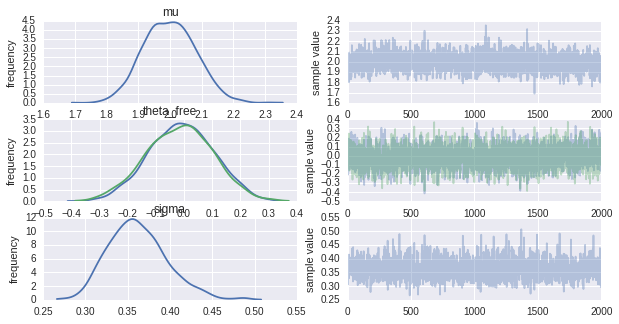

In [93]:
sns.boxplot(data = y)
plt.show()
print(fit)
fit.plot()
trace = fit.extract()

In [94]:
y = y_out
(N, K) = y.shape

data = {'K': K, 'N': N, 'y': y}
fit = model.sampling(data=data, iter=1000, chains=4)

/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction

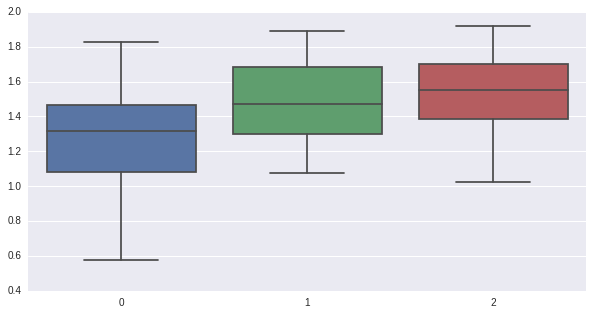

Inference for Stan model: anon_model_a6be83174308d49bd735f24dec530cac.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu              1.26  1.5e-3   0.07   1.14   1.22   1.26   1.31    1.4   2000    1.0
theta_free[0]   0.21  2.1e-3   0.09   0.01   0.15   0.21   0.27   0.39   2000    1.0
theta_free[1]   0.27  2.1e-3   0.09   0.08   0.21   0.27   0.34   0.45   2000    1.0
sigma           0.29  6.4e-4   0.03   0.24   0.27   0.29   0.31   0.35   2000    1.0
lp__            43.5    0.03   1.49  39.79  42.82  43.85  44.58  45.32   2000    1.0

Samples were drawn using NUTS(diag_e) at Sat Oct 15 04:12:49 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


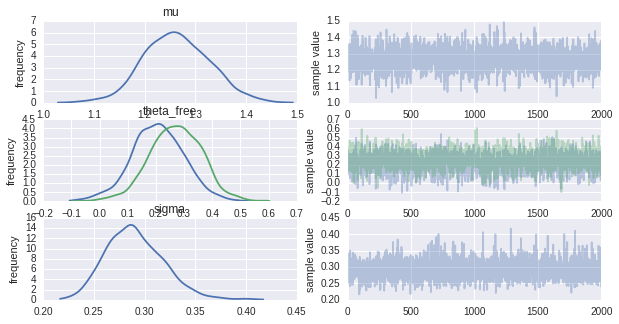

In [95]:
sns.boxplot(data = y)
plt.show()
print(fit)
fit.plot()
trace = fit.extract()

In [96]:
code = '''
data {
    int K; // Number of groups
    int N; // Number of examples per group
    real y_in[N, K]; // Observations (inside only)
    real y_out[N, K]; // Observations (including outsiders)
}
parameters {
    real mu_in; // Mean (inside only)
    real mu_out; // Mean (including outsiders)
    vector[K-1] theta_free; // Effects
    real<lower=0> sigma; // Noise std
}
model {
    vector[K] theta; // Effects including the first effect which shall be forced to zero for identifiability purposes
    theta[1] <- 0.0;
    for (i in 2:K) theta[i] <- theta_free[i-1];
    theta_free ~ normal(0, 100); // Weak effect prior

    sigma ~ normal(0, 100); // Weak noise std prior (half-normal)
    
    for (i in 1:N)
        for (j in 1:K) {
            // Normal likelihood
            y_in[i][j] ~ normal(mu_in + theta[j], sigma); 
            y_out[i][j] ~ normal(mu_out + theta[j], sigma);
        }
}
'''

model_two_way = pystan.StanModel(model_code=code)

/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction.py:50: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  cls(buf, protocol).dump(obj)
/home/tabacof/anaconda2/envs/python3/lib/python3.5/multiprocessing/reduction

Inference for Stan model: anon_model_ac213c0a0c07402918ec3daf2e163fab.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

                mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu_in           1.92  1.3e-3   0.06    1.8   1.88   1.92   1.96   2.04   2000    1.0
mu_out          1.35  1.4e-3   0.06   1.23   1.31   1.35   1.39   1.47   2000    1.0
theta_free[0]   0.09  1.6e-3   0.07  -0.05   0.05   0.09   0.14   0.24   2000    1.0
theta_free[1]   0.13  1.6e-3   0.07  -0.02   0.08   0.13   0.17   0.26   2000    1.0
sigma           0.33  5.1e-4   0.02   0.28   0.31   0.33   0.34   0.38   2000    1.0
lp__           72.89    0.04   1.59  68.95  72.07  73.21  74.04  75.04   2000    1.0

Samples were drawn using NUTS(diag_e) at Sat Oct 15 04:13:14 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergen

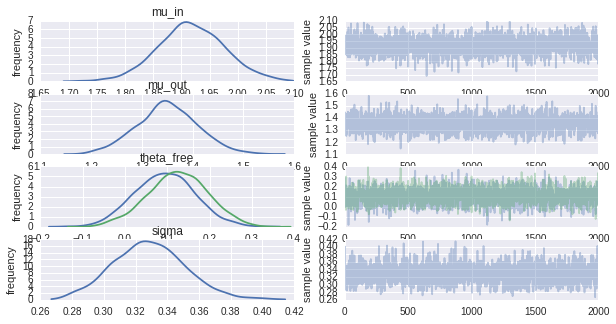

In [97]:
data = {'K': K, 'N': N, 'y_in': y_in, 'y_out': y_out}
fit = model_two_way.sampling(data=data, iter=1000, chains=4)
print(fit)
fit.plot()
trace = fit.extract()